In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image as PILImage
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.ops import MultiScaleRoIAlign, nms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Создание Dataset и Dataloader (без изменений)

class ParkingDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.split = split
        self.transform = transform
        
        annotations_path = os.path.join(self.root_dir, '_annotations.coco.json')
        with open(annotations_path, 'r') as f:
            data = json.load(f)
        
        self.images = {img['id']: img for img in data['images']}
        self.annotations = {img_id: [] for img_id in self.images.keys()}
        
        self.categories = {cat['id']: cat['name'] for cat in data['categories']}
        self.category_ids = {cat['name']: cat['id'] for cat in data['categories']}
        
        for ann in data['annotations']:
            img_id = ann['image_id']
            if img_id in self.annotations:
                self.annotations[img_id].append(ann)
        
        self.samples = []
        for img_id, img_info in self.images.items():
            img_path = os.path.join(self.root_dir, img_info['file_name'])
            if os.path.exists(img_path):
                anns = self.annotations.get(img_id, [])
                self.samples.append((img_path, anns))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, anns = self.samples[idx]
        img = PILImage.open(img_path).convert('RGB')
        
        boxes = []
        labels = []
        
        for ann in anns:
            x_min, y_min, width, height = ann['bbox']
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(ann['category_id'])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        if len(boxes) > 0:
            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
            }
        else:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
        
        if self.transform:
            img = self.transform(img)
        
        return img, target

def get_transform(split):
    if split == 'train':
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else: 
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def collate_fn(batch):
    return tuple(zip(*batch))

In [3]:
# Датасеты и даталоадеры
root = "data_mini"

train_dataset = ParkingDataset(root, split='train', transform=get_transform('train'))
valid_dataset = ParkingDataset(root, split='valid', transform=get_transform('valid'))
test_dataset = ParkingDataset(root, split='test', transform=get_transform('test'))

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

CLASS_COLORS = {
    0: 'red',
    1: 'lime',
    2: 'blue'
}
DEFAULT_COLOR = 'white'

In [4]:
# Модель Faster R-CNN на ResNet18
def create_faster_rcnn_resnet18(num_classes):
    weights = ResNet18_Weights.IMAGENET1K_V1
    backbone = resnet18(weights=weights)
    backbone = nn.Sequential(*list(backbone.children())[:-2])
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_dataset.categories) + 1

In [5]:
# Функции обучения и валидации
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, targets in tqdm(loader, desc="Train"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_loss += losses.item()
    return total_loss / len(loader)

def validate_epoch(model, loader, device):
    model.train()  # FasterRCNN возвращает loss только в train mode
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Val"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(loader)

In [6]:
# Вычисление mAP
def compute_map(model, loader, device):
    model.eval()
    metric = MeanAveragePrecision(class_metrics=True)
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Вычисление mAP"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            preds = model(images)
            metric.update(preds, targets)
    result = metric.compute()
    metric.reset()
    return result['map_50'].item()

In [ ]:
# Обучение
def train_model(model, train_loader, valid_loader, optimizer, scheduler, file_name, num_epochs=10):
    history = {'train_loss': [], 'valid_loss': [], 'map50': []}
    best_map50 = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nЭпоха {epoch+1}/{num_epochs}")
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = validate_epoch(model, valid_loader, device)
        
        map50 = compute_map(model, valid_loader, device)
        
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(val_loss)
        history['map50'].append(map50)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mAP@0.5: {map50:.4f}")
        
        scheduler.step()
        
        if map50 > best_map50:
            best_map50 = map50
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'map50': best_map50,
                'train_loss': train_loss,
                'valid_loss': val_loss,
            }, file_name)
            print(f"Сохранена лучшая модель с mAP@0.5 = {best_map50:.4f}")
    
    return history

In [8]:
model = create_faster_rcnn_resnet18(num_classes).to(device)

backbone_params = list(model.backbone.parameters())
other_params = list(model.rpn.parameters()) + list(model.roi_heads.parameters())

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': other_params, 'lr': 1e-3}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)

history = train_model(model=model, train_loader=train_loader, valid_loader=valid_loader,
                      optimizer=optimizer, scheduler=scheduler, file_name="best_faster_rcnn.pth", num_epochs=5)


Эпоха 1/5


Вычисление mAP: 100%|██████████| 42/42 [00:46<00:00,  1.11s/it]


Train Loss: 1.9313 | Val Loss: 1.0301 | mAP@0.5: 0.2477
Сохранена лучшая модель с mAP@0.5 = 0.2477

Эпоха 2/5


Вычисление mAP: 100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


Train Loss: 0.9197 | Val Loss: 0.8422 | mAP@0.5: 0.3935
Сохранена лучшая модель с mAP@0.5 = 0.3935

Эпоха 3/5


Вычисление mAP: 100%|██████████| 42/42 [00:44<00:00,  1.07s/it]


Train Loss: 0.7650 | Val Loss: 0.6868 | mAP@0.5: 0.5198
Сохранена лучшая модель с mAP@0.5 = 0.5198

Эпоха 4/5


Вычисление mAP: 100%|██████████| 42/42 [00:45<00:00,  1.08s/it]


Train Loss: 0.6452 | Val Loss: 0.6038 | mAP@0.5: 0.5934
Сохранена лучшая модель с mAP@0.5 = 0.5934

Эпоха 5/5


Вычисление mAP: 100%|██████████| 42/42 [00:45<00:00,  1.07s/it]


Train Loss: 0.5572 | Val Loss: 0.5251 | mAP@0.5: 0.6559
Сохранена лучшая модель с mAP@0.5 = 0.6559


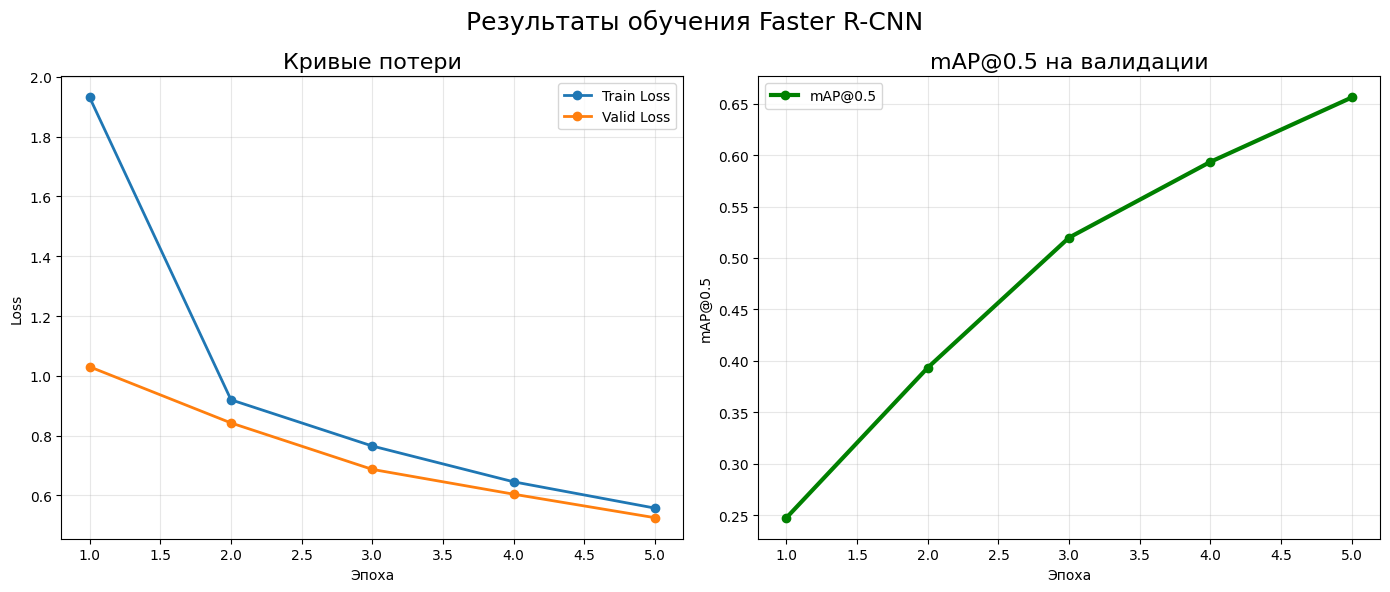

<Figure size 600x250 with 0 Axes>

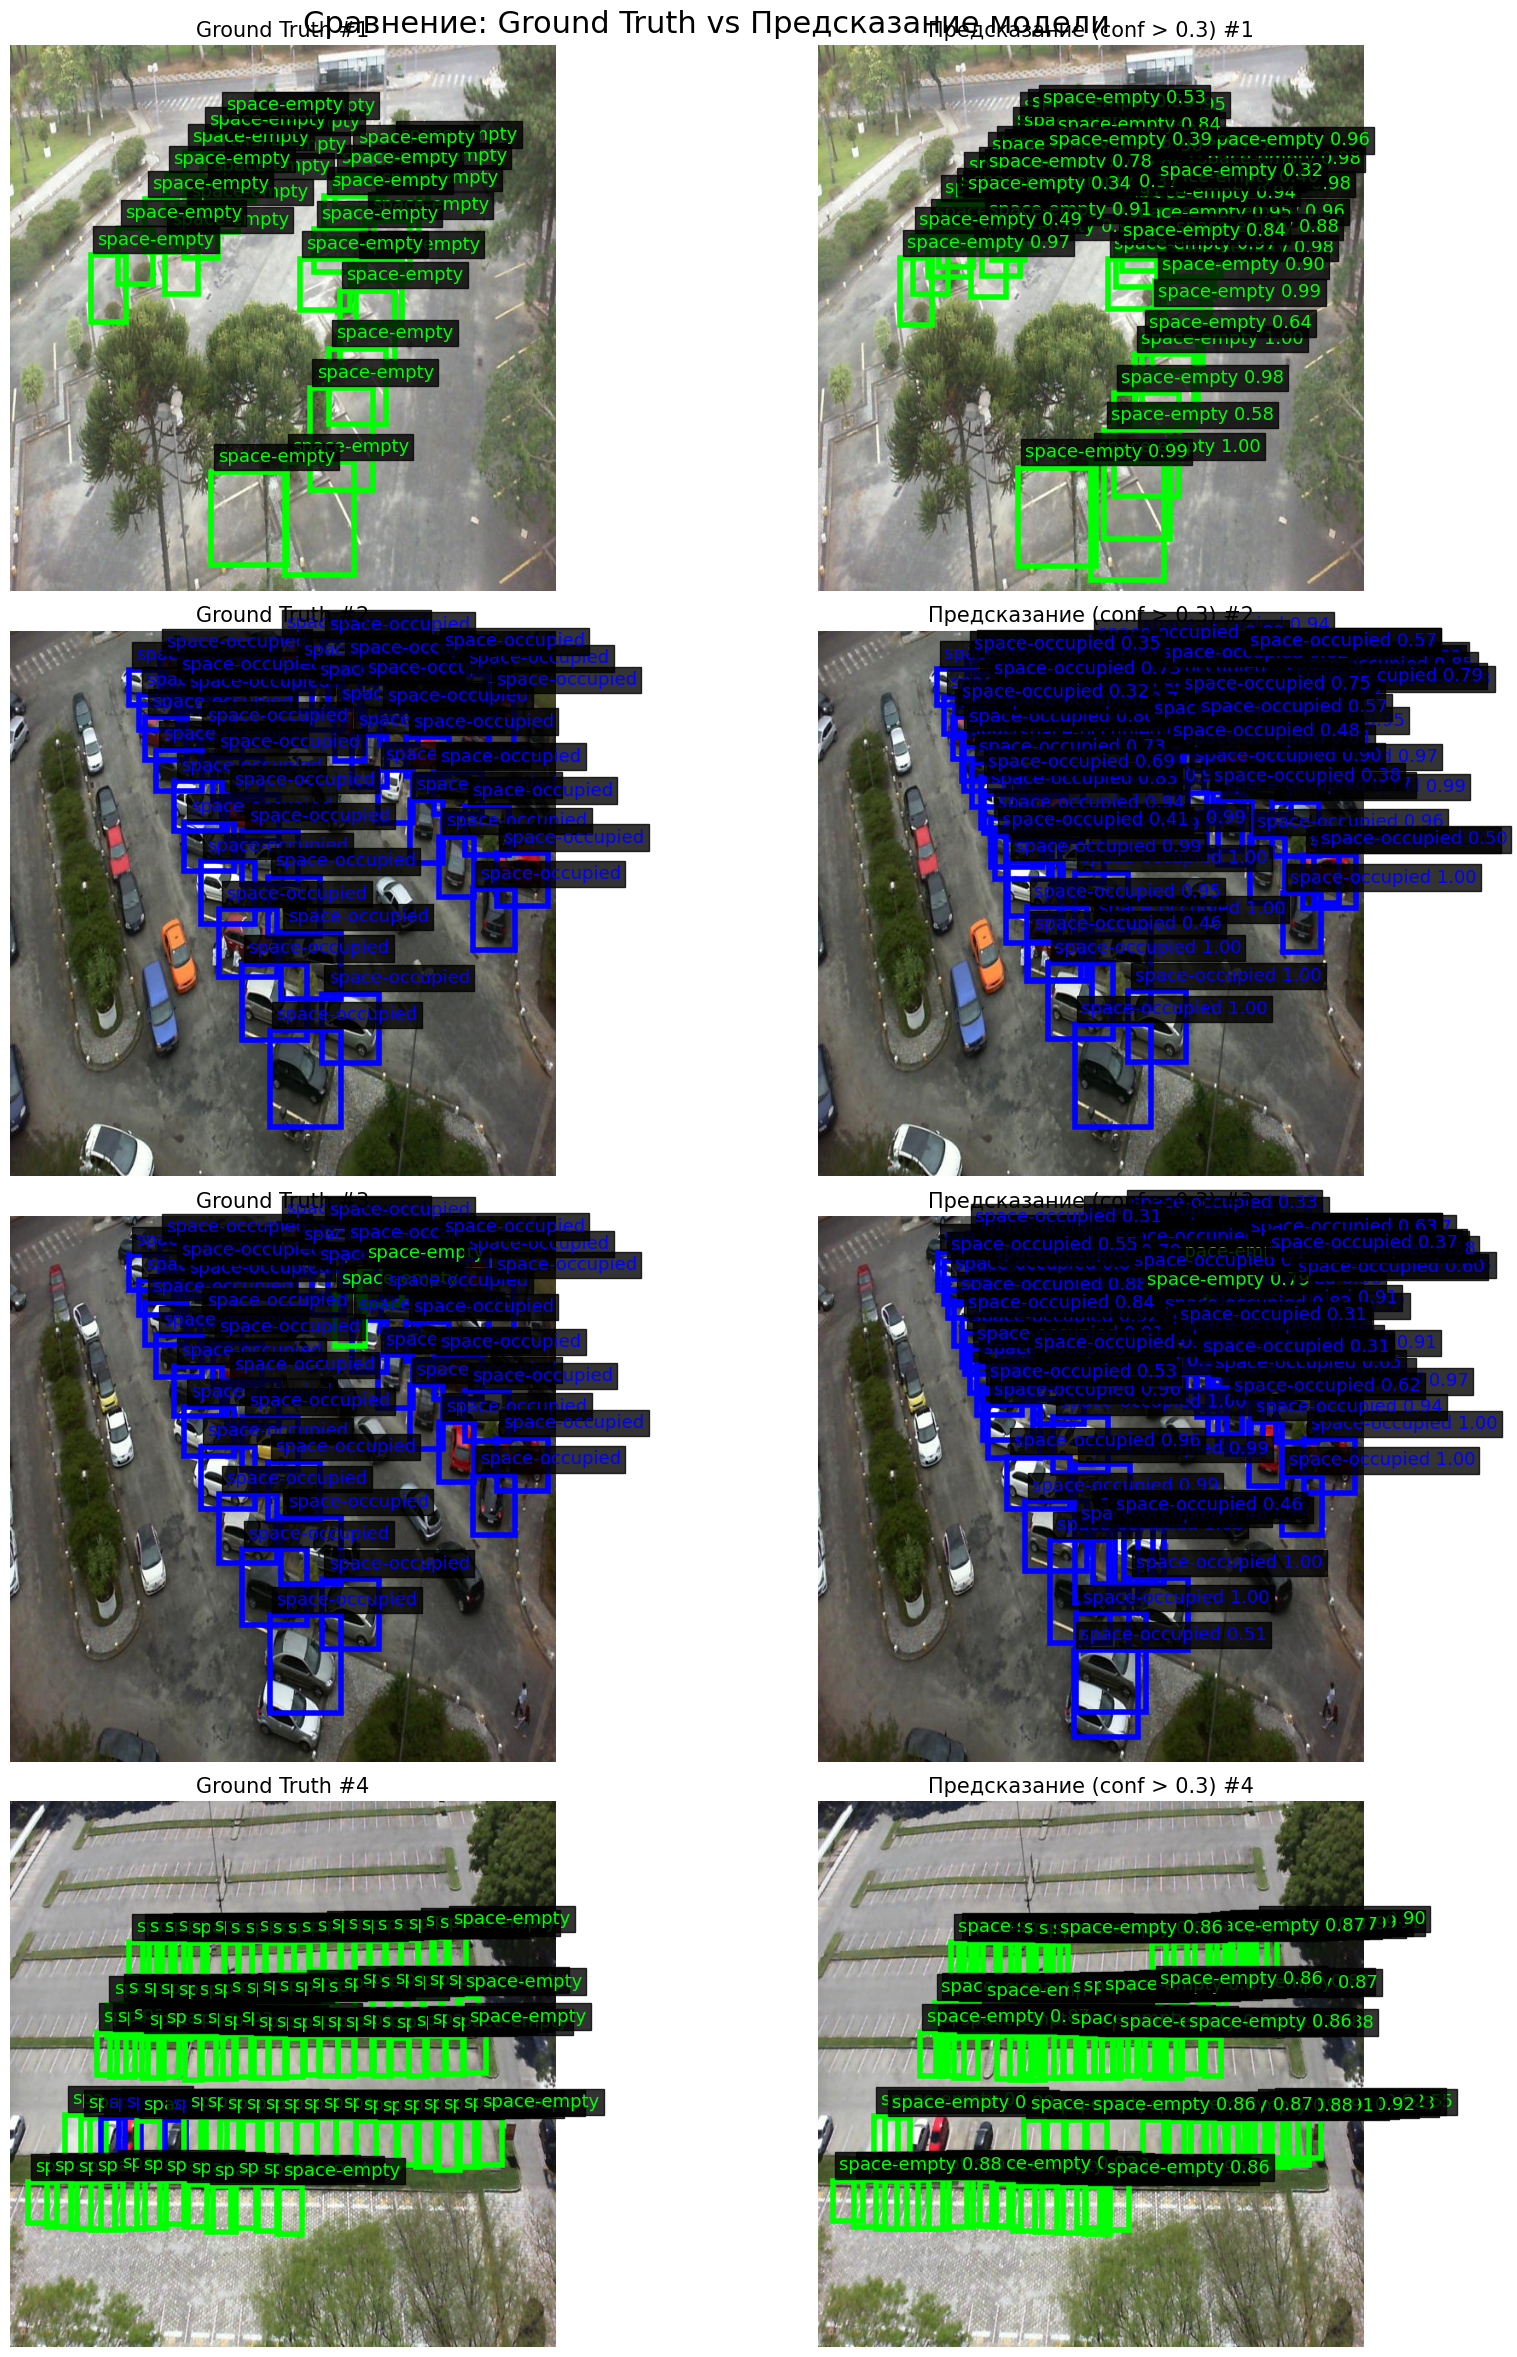

In [9]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import nms

# ================================== ВИЗУАЛИЗАЦИЯ ==================================

def visualize_results(model, history, valid_dataset, device, num_images=5, conf_threshold=0.3):
    model.eval()
    idx_to_cat_name = {0: 'background', **valid_dataset.categories}

    # 1. Графики обучения
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o', linewidth=2, color='tab:blue')
    plt.plot(epochs, history['valid_loss'], label='Valid Loss', marker='o', linewidth=2, color='tab:orange')
    plt.title('Кривые потери', fontsize=16)
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['map50'], label='mAP@0.5', marker='o', linewidth=3, color='green')
    plt.title('mAP@0.5 на валидации', fontsize=16)
    plt.xlabel('Эпоха')
    plt.ylabel('mAP@0.5')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle('Результаты обучения Faster R-CNN', fontsize=18)
    plt.tight_layout()
    plt.show()

    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor=CLASS_COLORS.get(i, 'black'),
                      linewidth=4, label=idx_to_cat_name.get(i, f'class_{i}'))
        for i in sorted(valid_dataset.categories.keys())
    ]
    legend_fig = plt.figure(figsize=(6, 1 + 0.5 * len(legend_elements)))
    legend_fig.legend(handles=legend_elements, loc='center', ncol=2, title="Классы", fontsize=12, title_fontsize=14)
    legend_fig.tight_layout()
    plt.show()

    # 2. Сравнение: Ground Truth vs Предсказание
    indices = random.sample(range(len(valid_dataset)), min(num_images, len(valid_dataset)))

    fig = plt.figure(figsize=(18, 6 * len(indices)))

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    for plot_idx, idx in enumerate(indices):
        img, target = valid_dataset[idx]

        # Денормализация изображения
        img_denorm = img * std[:, None, None] + mean[:, None, None]
        img_denorm = torch.clamp(img_denorm, 0.0, 1.0)
        img_np = img_denorm.permute(1, 2, 0).cpu().numpy()

        # Ground Truth 
        ax_gt = plt.subplot(len(indices), 2, plot_idx * 2 + 1)
        ax_gt.imshow(img_np)
        for box, label_tensor in zip(target['boxes'], target['labels']):
            label = label_tensor.item()
            color = CLASS_COLORS.get(label, 'lime')
            x1, y1, x2, y2 = box.cpu().numpy()

            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=4, edgecolor=color, facecolor='none'
            )
            ax_gt.add_patch(rect)

            class_name = idx_to_cat_name.get(label, 'unknown')
            ax_gt.text(x1 + 8, y1 - 12, class_name, color=color, fontsize=13,
                       bbox=dict(facecolor='black', alpha=0.8, pad=3))

        ax_gt.set_title(f'Ground Truth #{plot_idx + 1}', fontsize=15)
        ax_gt.axis('off')

        # Предсказание 
        ax_pred = plt.subplot(len(indices), 2, plot_idx * 2 + 2)
        ax_pred.imshow(img_np)

        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        if len(prediction['boxes']) > 0:
            # NMS
            keep = nms(prediction['boxes'], prediction['scores'], iou_threshold=0.5)
            scores = prediction['scores'][keep]
            mask = scores > conf_threshold
            boxes = prediction['boxes'][keep][mask]
            labels = prediction['labels'][keep][mask]
            scores = scores[mask]

            for box, label_tensor, score in zip(boxes, labels, scores):
                label = label_tensor.item()
                color = CLASS_COLORS.get(label, 'red')
                x1, y1, x2, y2 = box.cpu().numpy()

                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=4, edgecolor=color, facecolor='none'
                )
                ax_pred.add_patch(rect)

                class_name = idx_to_cat_name.get(label, 'unknown')
                text = f'{class_name} {score.item():.2f}'
                ax_pred.text(x1 + 8, y1 - 12, text, color=color, fontsize=13,
                             bbox=dict(facecolor='black', alpha=0.8, pad=3))

        ax_pred.set_title(f'Предсказание (conf > {conf_threshold}) #{plot_idx + 1}', fontsize=15)
        ax_pred.axis('off')

    plt.suptitle('Сравнение: Ground Truth vs Предсказание модели', fontsize=22, y=0.98)
    plt.tight_layout()
    plt.show()

# ================================== ВЫЗОВ ==================================
visualize_results(model, history, valid_dataset, device, num_images=4, conf_threshold=0.3)